In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import median, percentile_approx, min, max
from pyspark.sql.functions import col, lower, trim, regexp_replace, count, when, isnull, mean, stddev, countDistinct
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.sql.window import Window
from pyspark.sql.functions import median, percentile_approx, min, max
from pyspark.ml import Pipeline

#starting spark session
spark = SparkSession.builder.appName("clean_data").getOrCreate()

#loading data here
file_path = "/content/Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System.csv"
#spark reads csv that is given
df = spark.read.csv(file_path, header=True, inferSchema=True)

#handling column selection, cleaning, and handling missing data/nulls

#columns selection
#1
columns_selected = ['YearStart','LocationDesc','Topic','Question','Data_Value','Education', 'Income','Race/Ethnicity']
df = df.select(columns_selected)

#flitering of data to find relevant information about obesity
keywords_to_find =["Obesity", "Overweight", "BMI","Weight Status"]
check = None
for keyword in keywords_to_find:
    if check is None:
        check = (col("Topic").contains(keyword)) | (col("Question").contains(keyword))
    else:
        check = check | (col("Topic").contains(keyword)) | (col("Question").contains(keyword))
df = df.filter(check)

#renaming columns for relevance and handling missing value/nulls
df = df.withColumnRenamed("YearStart", "year").withColumnRenamed("LocationDesc", "state").withColumnRenamed("Data_Value", "obesity_rate")

#2
#handling missing values
missing_values = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
total_rows = df.count()
missing_percent = missing_values.select(*[(col(c)/total_rows*100).alias(f"{c}_missing_pct") for c in df.columns])

#nulls dropped
df = df.na.drop(subset=["obesity_rate", "state"])
df = df.fillna({"Education": "Not Reported","Income": "Unknown","Race/Ethnicity": "Not Specified",})

#ensuring consistency of data
#obesity rates not in the negatives or higher than 100
df = df.filter((col("obesity_rate")>= 0)&(col("obesity_rate") <= 100))

#relevalent year ranges
df = df.filter((col("year") > 2009) &(col("year") < 2024))

#removing duplicates just incase
df = df.dropDuplicates()


#scaling numeric features
assemble = VectorAssembler(inputCols=["obesity_rate"],outputCol="obesity_vector")
scale =MinMaxScaler(inputCol="obesity_vector",outputCol="obesity_scaled")

pipline = Pipeline(stages=[assemble, scale])
scaled_model = pipline.fit(df)
scaled = scaled_model.transform(df)
#show data
scaled.select("obesity_rate", "obesity_scaled").show(5, truncate=False)

#changing columns/test to loweer case for better processing
text_cols = ["state", "Education", "Income", "Race/Ethnicity"]
for column in text_cols:df = df.withColumn(column,trim(lower(regexp_replace(col(column), "[^a-zA-Z0-9 ]", ""))))


#using window to calculate outliers and filter outliers
#windows technique
#3
window_spec = Window.partitionBy("state")

df = df.withColumn("state_median", median("obesity_rate").over(window_spec)).withColumn("state_iqr", percentile_approx("obesity_rate", 0.75).over(window_spec) -percentile_approx("obesity_rate", 0.25).over(window_spec)).withColumn("lower_bound", col("state_median") - 1.5 * col("state_iqr")).withColumn("upper_bound", col("state_median") + 1.5 * col("state_iqr"))

#outliers filtering for obesity
df = df.filter((col("obesity_rate") >= col("lower_bound")) &(col("obesity_rate") <= col("upper_bound"))).drop("state_median", "state_iqr", "lower_bound", "upper_bound")
#checking data
df.show(5, truncate=False)

#saving clean data as csv
path = "cleaned_data.csv"
df.coalesce(1).write.csv(path,header=True,mode="overwrite")
#spilt data
#4
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
train_path = "obesity_train.csv"
test_path = "obesity_test.csv"

train_data.coalesce(1).write.csv(train_path, header=True, mode="overwrite")
test_data.coalesce(1).write.csv(test_path, header=True, mode="overwrite")

scaled.explain(True)
#stop spark
spark.stop()


+------------+---------------------+
|obesity_rate|obesity_scaled       |
+------------+---------------------+
|38.1        |[0.52991452991453]   |
|31.4        |[0.43447293447293456]|
|36.5        |[0.5071225071225072] |
|38.4        |[0.5341880341880343] |
|36.3        |[0.5042735042735044] |
+------------+---------------------+
only showing top 5 rows

+----+-------+-----------------------+-------------------------------------------------------------------------------+------------+------------+---------------+--------------+
|year|state  |Topic                  |Question                                                                       |obesity_rate|Education   |Income         |Race/Ethnicity|
+----+-------+-----------------------+-------------------------------------------------------------------------------+------------+------------+---------------+--------------+
|2015|alabama|Obesity / Weight Status|Percent of adults aged 18 years and older who have obesity                  

Logistic Regression Performance:
Accuracy: 0.408
Precision: 0.652
Recall: 0.408
F1-Score: 0.267


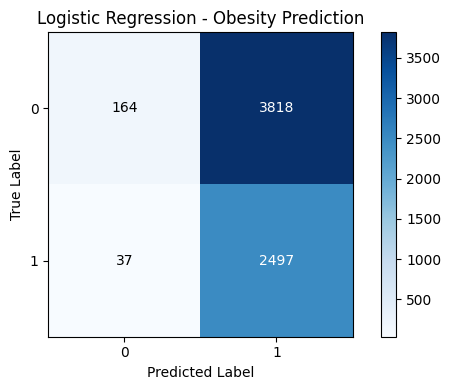

== Parsed Logical Plan ==
'Project [year#3702, state#3703, Topic#3704, Question#3705, obesity_rate#3706, Education#3707, Income#3708, Race/Ethnicity#3709, label#3718, weight#3773, edu_index#4276, state_index#4294, income_index#4313, race_index#4333, raw_features#4352, features#4371, rawPrediction#4393, probability#4414, UDF('rawPrediction) AS prediction#4438 AS prediction#4439]
+- Project [year#3702, state#3703, Topic#3704, Question#3705, obesity_rate#3706, Education#3707, Income#3708, Race/Ethnicity#3709, label#3718, weight#3773, edu_index#4276, state_index#4294, income_index#4313, race_index#4333, raw_features#4352, features#4371, rawPrediction#4393, UDF(rawPrediction#4393) AS probability#4414]
   +- Project [year#3702, state#3703, Topic#3704, Question#3705, obesity_rate#3706, Education#3707, Income#3708, Race/Ethnicity#3709, label#3718, weight#3773, edu_index#4276, state_index#4294, income_index#4313, race_index#4333, raw_features#4352, features#4371, UDF(features#4371) AS rawPredic

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#start Spark
spark = SparkSession.builder.appName("Obesity_Logistic_Regression").getOrCreate()


df = spark.read.option("header", True).csv("cleaned_data.csv", inferSchema=True)

#binary label: 1 if obesity_rate > 35 else 0
df = df.withColumn("label", when(col("obesity_rate") > 35, 1).otherwise(0))

#class weights to handle imbalance
total = df.count()
class_0 = df.filter(col("label") == 0).count()
class_1 = df.filter(col("label") == 1).count()
weight_0 = total / (2.0 * class_0)  #weight for class 0
weight_1 = total / (2.0 * class_1)  #weight for class 1
df = df.withColumn("weight", when(col("label") == 0, weight_0).otherwise(weight_1))

#index categorical features
edu_indexer = StringIndexer(inputCol="Education", outputCol="edu_index", handleInvalid="keep")
state_indexer = StringIndexer(inputCol="state", outputCol="state_index", handleInvalid="keep")
income_indexer = StringIndexer(inputCol="Income", outputCol="income_index", handleInvalid="keep")
race_indexer = StringIndexer(inputCol="Race/Ethnicity", outputCol="race_index", handleInvalid="keep")

assembler = VectorAssembler(
    inputCols=["edu_index", "state_index", "income_index", "race_index"],
    outputCol="raw_features"
)

#scale features
scaler = MinMaxScaler(inputCol="raw_features", outputCol="features")

#logistic Regression with class weights
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    weightCol="weight",
    maxIter=100,
    threshold=0.4
)

#pipeline
pipeline = Pipeline(stages=[edu_indexer, state_indexer, income_indexer, race_indexer, assembler, scaler, lr])

#split data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

#train model
model = pipeline.fit(train_data)


predictions = model.transform(test_data)


evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

#confusion Matrix
pandas_df = predictions.select("label", "prediction").toPandas()
cm = pd.crosstab(pandas_df["label"], pandas_df["prediction"],
                 rownames=["True Label"], colnames=["Predicted Label"]).values

plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Logistic Regression - Obesity Prediction")
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ["0", "1"])
plt.yticks(tick_marks, ["0", "1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# To view DAG and execution plan
model.stages[-1].explainParams()
predictions.explain(True)
predictions.show()

spark.stop()


Silhouette Score: 0.655
+-------+------------------+------------------+-------------------+
|cluster| avg(obesity_rate)|  avg(state_index)|     avg(edu_index)|
+-------+------------------+------------------+-------------------+
|      0| 33.73310977762075|39.294811154253445|0.05118249205788916|
|      1|32.826615866104206|12.348754932643898| 0.0532725540889917|
|      2| 33.30088473205257|   26.762891809909| 2.9777553083923154|
+-------+------------------+------------------+-------------------+



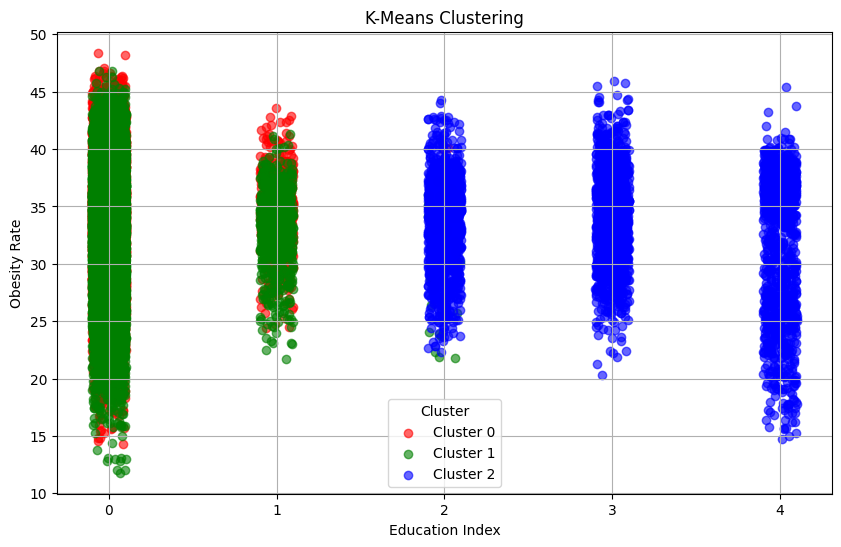

== Parsed Logical Plan ==
'Project [year#4653, state#4654, Topic#4655, Question#4656, obesity_rate#4657, Education#4658, Income#4659, Race/Ethnicity#4660, edu_index#4917, state_index#4933, raw_features#4948, features#4963, UDF('features) AS cluster#4981 AS cluster#4982]
+- Project [year#4653, state#4654, Topic#4655, Question#4656, obesity_rate#4657, Education#4658, Income#4659, Race/Ethnicity#4660, edu_index#4917, state_index#4933, raw_features#4948, UDF(raw_features#4948) AS features#4963]
   +- Project [year#4653, state#4654, Topic#4655, Question#4656, obesity_rate#4657, Education#4658, Income#4659, Race/Ethnicity#4660, edu_index#4917, state_index#4933, UDF(struct(obesity_rate, obesity_rate#4657, edu_index, edu_index#4917, state_index, state_index#4933)) AS raw_features#4948]
      +- Project [year#4653, state#4654, Topic#4655, Question#4656, obesity_rate#4657, Education#4658, Income#4659, Race/Ethnicity#4660, edu_index#4917, UDF(cast(state#4654 as string)) AS state_index#4933]
     

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#start Spark
spark = SparkSession.builder.appName("Obesity_KMeans").getOrCreate()

#load cleaned data
df = spark.read.option("header", True).csv("cleaned_data.csv", inferSchema=True)

#index categorical features
edu_indexer = StringIndexer(inputCol="Education", outputCol="edu_index", handleInvalid="keep")
state_indexer = StringIndexer(inputCol="state", outputCol="state_index", handleInvalid="keep")

assembler = VectorAssembler(inputCols=["obesity_rate", "edu_index", "state_index"], outputCol="raw_features")

#scale features
scaler = MinMaxScaler(inputCol="raw_features", outputCol="features")

#KMeans
kmeans = KMeans(k=3, seed=1, featuresCol="features", predictionCol="cluster")

#pipeline
pipeline = Pipeline(stages=[edu_indexer, state_indexer, assembler, scaler, kmeans])
model = pipeline.fit(df)

#predict clusters
clustered_df = model.transform(df)

#valuate clustering
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster")
silhouette_score = evaluator.evaluate(clustered_df)
print(f"Silhouette Score: {silhouette_score:.3f}")

#cluster summary
cluster_summary = clustered_df.groupBy("cluster").agg(
    {"obesity_rate": "mean", "edu_index": "mean", "state_index": "mean"}
).orderBy("cluster")
cluster_summary.show()


colors = ['red', 'green', 'blue']
pandas_df = clustered_df.select("obesity_rate", "edu_index", "cluster").toPandas()

plt.figure(figsize=(10, 6))
for cluster in sorted(pandas_df['cluster'].unique()):
    subset = pandas_df[pandas_df['cluster'] == cluster]
    jitter = np.random.uniform(-0.1, 0.1, size=len(subset))
    x_jittered = subset["edu_index"] + jitter
    plt.scatter(x_jittered, subset["obesity_rate"], label=f"Cluster {cluster}",
                color=colors[cluster % len(colors)], alpha=0.6)

plt.xlabel("Education Index")
plt.ylabel("Obesity Rate")
plt.title("K-Means Clustering")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

clustered_df.explain(True)


spark.stop()

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

#Linear Regression
#feature encoding
#using education vs obesity rate here
indexer = StringIndexer(inputCol="Education", outputCol="Education_index1")
encoder = OneHotEncoder(inputCol="Education_index1", outputCol="Education_encode")

#assembling pipline and performing linear regression
assem = VectorAssembler(inputCols=["Education_encode"], outputCol="feats")
linear_regression = LinearRegression(featuresCol="feats", labelCol="obesity_rate", predictionCol="predicts")
pipeline = Pipeline(stages=[indexer, encoder, assem, linear_regression]) #pipeline
model = pipeline.fit(train_data)
#transforming on data
predictions = model.transform(test_data)
predictions.select("Education", "obesity_rate", "predicts").show(5, truncate=False)

#DAG ANALYSIS
predictions.explain(True)

for i, stage in enumerate(model.stages):
    print(f"Stage {i}: {stage}")
#evaluation
evaluation = RegressionEvaluator(labelCol="obesity_rate", predictionCol="predicts", metricName="rmse")
#root mean square error
root_mean_square_error = evaluation.evaluate(predictions)
print(f"root mean square error:{root_mean_square_error:.2f}") #root mean square error
lr_model = model.stages[-1]
print(f"Coefficients:{lr_model.coefficients}")
print(f"Intercept:{lr_model.intercept}")

mean_absolute_error = evaluation.setMetricName("mae").evaluate(predictions)
print(f"mean absolute error:{mean_absolute_error:.2f}")

R2 = evaluation.setMetricName("r2").evaluate(predictions)
print(f"R^2 score:{R2}")

#plotting
switch_panadas = predictions.select("Education", "obesity_rate", "predicts").toPandas()
grouping = switch_panadas.groupby("Education")[["obesity_rate", "predicts"]].mean().reset_index()
grouping = grouping.sort_values("Education")
plt.figure(figsize=(10, 6))
plt.plot(grouping["Education"], grouping["obesity_rate"], marker="o", label="Actual", color="green")
plt.plot(grouping["Education"], grouping["predicts"], marker="o", label="Predicted", color="skyblue")
plt.xlabel("Education Level")
plt.ylabel("Obesity Rate (%)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
from pyspark.sql.functions import when
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

#data distribution
df = df.withColumn("obesity_class",when(col("obesity_rate") < 30, "low").when(col("obesity_rate") < 35, "medium").otherwise("high"))

#indexer
indexer_ed = StringIndexer(inputCol="Education", outputCol="Education_index1")
indexer_in = StringIndexer(inputCol="Income", outputCol="Income_index1")
indexer_ra = StringIndexer(inputCol="Race/Ethnicity", outputCol="Race_index1")
label_indexer = StringIndexer(inputCol="obesity_class", outputCol="label")

#indexer
assembler = VectorAssembler(inputCols=["Education_index1", "Income_index1", "Race_index1"],outputCol="feats")

#set up random forest
random_forest = RandomForestClassifier(featuresCol="feats",labelCol="label",numTrees=200,maxDepth=20,seed=42)
#workflow
pipeline = Pipeline(stages=[indexer_ed, indexer_in, indexer_ra,label_indexer,assembler,random_forest])
#split data
train_data, test_data = df.randomSplit([0.8, 0.2],seed=42)
#fiting model
model =pipeline.fit(train_data)
predictions = model.transform(test_data)
#DAG ANALYSIS
predictions.explain(True)

for i, stage in enumerate(model.stages):
    print(f"Stage {i}: {stage}")
#evacualte
evaluator = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction")

#metrics
print("accuracy:", evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print("precision:", evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"}))
print("f1:",evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
print("recall:", evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}))

#importancs
importances = model.stages[-1].featureImportances.toArray()
feates = ["Education", "Income", "Race"]

#plot
plt.figure(figsize=(10,5))
pd.DataFrame({"Feature":feates, "Importance":importances}).sort_values("Importance", ascending=False).plot.bar(x="Feature", y="Importance")
plt.title("Importance")
plt.show()

In [ ]:
from pyspark.ml.classification import LinearSVC

#getting label for obesity rate
df = df.withColumn("label", when(col("obesity_rate") >= 30, 1).otherwise(0))
#categorize education,income, race/ethincity, no continusous values
cols = ["Education", "Income", "Race/Ethnicity"]
index = [StringIndexer(inputCol=i, outputCol=i+ "_index")for i in cols]
encode = [OneHotEncoder(inputCol=i + "_index", outputCol=i + "_vec")for i in cols]
#vector format
assembler =VectorAssembler(inputCols=[i + "_vec" for i in cols],outputCol="feats")

#prep svm
svm = LinearSVC(featuresCol="feats", labelCol="label", maxIter=10)
#workflow  set up for model
pipeline =Pipeline(stages=index + encode +[assembler,svm])
#data spilt
train_data,test_data =df.randomSplit([0.8, 0.2], seed=42)
#train model
model = pipeline.fit(train_data)

#predictions made
predictions = model.transform(test_data)
#DAG ANALYSIS
predictions.explain(True)

for i, stage in enumerate(model.stages):
    print(f"Stage {i}: {stage}")

#evalutation
evaluation = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

#calc meteics
accuracy =evaluation.evaluate(predictions,{evaluation.metricName: "accuracy"})
f1 = evaluation.evaluate(predictions, {evaluation.metricName: "f1"})
precision = evaluation.evaluate(predictions, {evaluation.metricName: "weightedPrecision"})
recall = evaluation.evaluate(predictions, {evaluation.metricName: "weightedRecall"})

#metrics
print(f"accuracy: {accuracy}")
print(f"f1 Score: {f1}")
print(f"precision: {precision}")
print(f"recall: {recall}")

#Confusion matrix for plot
conf_matrix = predictions.crosstab("label", "prediction").toPandas()

#DAG ANALYSIS

#plot
results_pd = predictions.toPandas()
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
conf_matrix = pd.crosstab(results_pd['label'], results_pd['prediction'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')